https://www.mdpi.com/2306-5729/6/2/14

# Libraries

In [1]:
import keras
import tensorflow.keras as keras
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras import mixed_precision
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight


2025-08-06 08:35:57.297149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754469357.490647      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754469357.548373      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data

In [2]:
train_dir = '/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training/'
val_dir = '/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation/'
test_dir = '/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/'

train_label_csv = '/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv'
val_label_csv = '/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv'
test_label_csv = '/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv'

In [3]:
train_label_df = pd.read_csv(train_label_csv)
val_label_df = pd.read_csv(val_label_csv)
test_label_df = pd.read_csv(test_label_csv)

In [4]:
train_label_df.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_label_df.columns

Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
       'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
       'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'CWS',
       'CB', 'ODPM', 'PRH', 'MNF', 'HR', 'CRAO', 'TD', 'CME', 'PTCR', 'CF',
       'VH', 'MCA', 'VS', 'BRAO', 'PLQ', 'HPED', 'CL'],
      dtype='object')

* Diabetic retinopathy (DR)
* Age-related macular degeneration (ARMD)
* Media Haze (MH)
* Drusens (DN)
* Myopia (MYA)
* Branch retinal vein occlusion (BRVO)
* Tessellation (TSLN)
* Epiretinal membrane (ERM)
* Laser scars (LS)
* Macular scar (MS)
* Central serous retinopathy (CSR)
* Optic disc cupping (ODC)
* Central retinal vein occlusion (CRVO)
* Tortuous vessels (TV)
* Asteroid hyalosis (AH)
* Optic disc pallor (ODP)
* Optic disc edema (ODE)
* Shunt (ST)
* Anterior ischemic optic neuropathy (AION)
* Parafoveal telangiectasia (PT)
* Retinal traction (RT)
* Retinitis (RS)
* Chorioretinitis (CRS)
* Exudation (EDN)
* Retinal pigment epithelium changes (RPEC)
* Macular hole (MHL)
* Retinitis pigmentosa (RP)
* Cotton-wool spots (CWS)
* Coloboma (CB)
* Optic disc pit maculopathy (ODPM)
* Preretinal hemorrhage (PRH)
* Myelinated nerve fibers (MNF)
* Hemorrhagic retinopathy (HR)
* Central retinal artery occlusion (CRAO)
* Tilted disc (TD)
* Cystoid macular edema (CME)
* Post-traumatic choroidal rupture (PTCR)
* Choroidal folds (CF)
* Vitreous hemorrhage (VH)
* Macroaneurysm (MCA)
* Vasculitis (VS)
* Branch retinal artery occlusion (BRAO)
* Plaque (PLQ)
* Hemorrhagic pigment epithelial detachment (HPED)
* Collateral (CL)

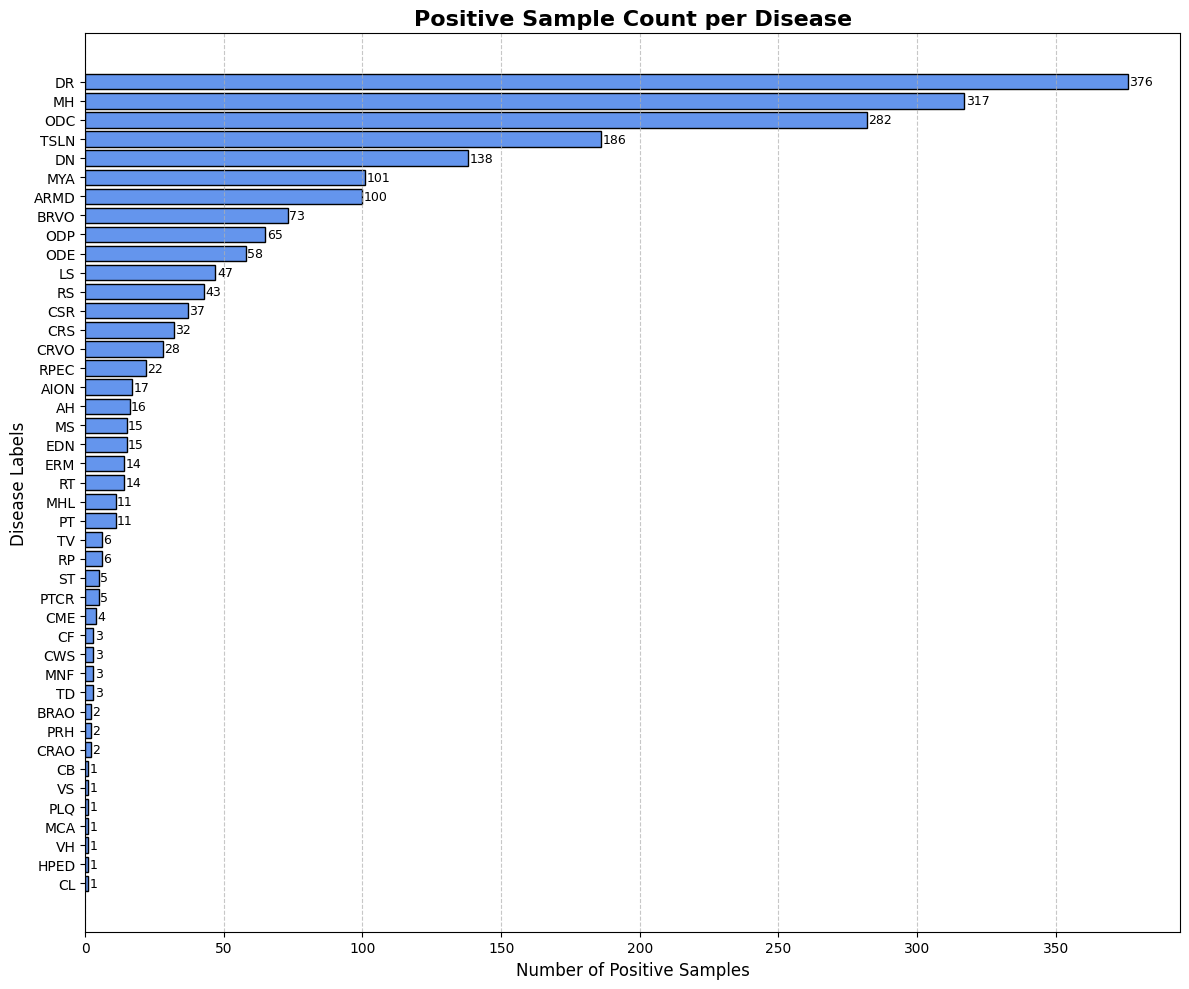

In [6]:
import matplotlib.pyplot as plt

# Extract label-only columns (assuming from 3rd column onward)
label_only_df = train_label_df.iloc[:, 2:]

# Count '1's (positive cases) per label
label_counts = (label_only_df == 1).sum().sort_values(ascending=False)

# Remove labels with zero positive samples
label_counts = label_counts[label_counts > 0]

# Plot with horizontal bars
fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.barh(label_counts.index, label_counts.values, color='cornflowerblue', edgecolor='black')

# Title and labels
ax.set_title("Positive Sample Count per Disease", fontsize=16, fontweight='bold')
ax.set_xlabel("Number of Positive Samples", fontsize=12)
ax.set_ylabel("Disease Labels", fontsize=12)

# Flip y-axis to show highest count on top
ax.invert_yaxis()

# Add value annotations to each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, str(int(width)),
            va='center', fontsize=9)

# Tweak layout for better spacing
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [7]:
train_label_df['ID'] = train_label_df['ID'].astype(str) + '.png'
val_label_df['ID'] = val_label_df['ID'].astype(str) + '.png'
test_label_df['ID'] = test_label_df['ID'].astype(str) + '.png'



In [8]:
train_label_df['ID'][:5]

0    1.png
1    2.png
2    3.png
3    4.png
4    5.png
Name: ID, dtype: object

In [9]:
train_label_clean = train_label_df.drop(['ID','Disease_Risk'], axis=1)
val_label_clean = val_label_df.drop(['ID','Disease_Risk'], axis=1)
test_label_clean = test_label_df.drop(['ID','Disease_Risk'], axis=1)

In [10]:
x_col = 'ID'
y_col_train = [col for col in train_label_clean.columns]
y_col_val = [col for col in val_label_clean.columns]
y_col_test = [col for col in test_label_clean.columns]

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define target image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Image data generators with rescaling
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# ✅ Flow from dataframe for multi-label classification
train_data = train_gen.flow_from_dataframe(
    dataframe=train_label_df,
    directory=train_dir,
    x_col=x_col,
    y_col=y_col_train,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    shuffle=True,
    class_mode="raw"  # ✅ for multi-label
)

val_data = val_gen.flow_from_dataframe(
    dataframe=val_label_df,
    directory=val_dir,
    x_col=x_col,
    y_col=y_col_val,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    shuffle=False,
    class_mode="raw"
)

test_data = test_gen.flow_from_dataframe(
    dataframe=test_label_df,
    directory=test_dir,
    x_col=x_col,
    y_col=y_col_test,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    shuffle=False,
    class_mode="raw"
)


Found 1920 validated image filenames.
Found 640 validated image filenames.
Found 640 validated image filenames.


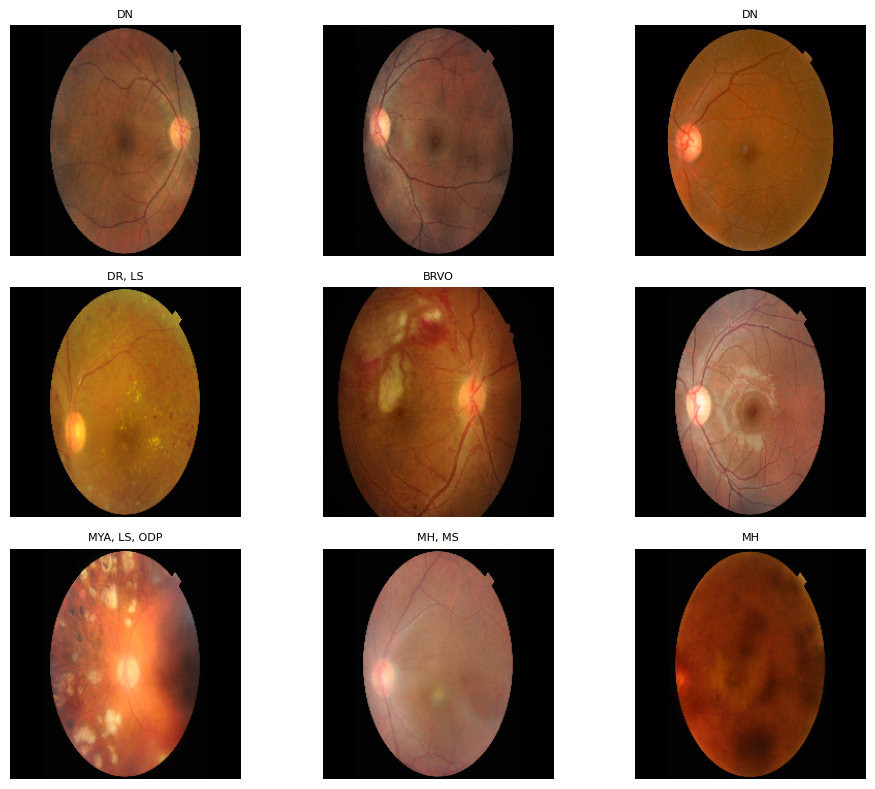

In [12]:

images, labels = next(train_data)
class_names = y_col_train

plt.figure(figsize=(10, 8))
for i in range(9):     #n²
    plt.subplot(3, 3, i+1)   #n
    plt.imshow(images[i])
    plt.axis('off')
    active_indices = np.where(labels[i] >= 0.5)[0]
    
    # Get corresponding class names
    active_class_names = [class_names[idx] for idx in active_indices]
    
    # Join labels as a string separated by commas
    label_str = ", ".join(active_class_names) 
    
    plt.title(label_str, fontsize=8)


plt.tight_layout()
plt.show()

In [13]:
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    
    # Decode image safely
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    
    # Resize to target size (you can replace with IMG_SIZE if defined globally)
    image = tf.image.resize(image, [224, 224])
    
    # Normalize to [0,1]
    image = tf.cast(image, tf.float32) / 255.0

    return image, label


In [14]:
def make_dataset(image_dir, label_df, batch_size=32, shuffle=True, cache=True):
    # Generate full image paths
    image_paths = label_df['ID'].apply(lambda x: os.path.join(image_dir, str(x))).values
    labels = label_df.iloc[:, 2:].values  # Skips 'ID' and 'Disease_Risk' columns

    # Create tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Apply preprocessing
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Optional caching, shuffling, batching
    if cache:
        dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


In [15]:
train_dataset = make_dataset(train_dir,train_label_df)
val_dataset = make_dataset(val_dir,val_label_df)
test_dataset = make_dataset(test_dir,test_label_df)

I0000 00:00:1754470132.862063      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754470132.862768      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [16]:
mixed_precision.set_global_policy("mixed_float16")

# Model

In [17]:

from tensorflow.keras import layers, Model
from tensorflow import keras

# Load VGG16 base model
base_model = keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers first
base_model.trainable = False

# Unfreeze last 4 layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Build the model
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(45, activation='sigmoid')(x)  # 45 binary labels for multi-label classification

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
)

Epoch 1/10


I0000 00:00:1754470290.770182     117 service.cc:148] XLA service 0x795c70009b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754470290.771374     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754470290.771399     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754470291.603633     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/60 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - auc: 0.5244 - binary_accuracy: 0.5752 - loss: 0.6791  

I0000 00:00:1754470310.068515     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - auc: 0.6212 - binary_accuracy: 0.8852 - loss: 0.3134 - val_auc: 0.8650 - val_binary_accuracy: 0.9759 - val_loss: 0.0874
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.8208 - binary_accuracy: 0.9735 - loss: 0.1012 - val_auc: 0.8770 - val_binary_accuracy: 0.9759 - val_loss: 0.0867
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.8436 - binary_accuracy: 0.9742 - loss: 0.0942 - val_auc: 0.8929 - val_binary_accuracy: 0.9761 - val_loss: 0.0825
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.8640 - binary_accuracy: 0.9751 - loss: 0.0909 - val_auc: 0.8963 - val_binary_accuracy: 0.9772 - val_loss: 0.0788
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - auc: 0.8798 - binary_accuracy: 0.9756 - loss: 0.0858 - val_auc: 0.9019 - val_binary_accuracy: 0.9783 - val_loss: 0.0761
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - auc: 0.8869 - binary_accuracy: 0.9765 - loss: 0.0838 - val_auc: 0.9018 - val_binary_accuracy:

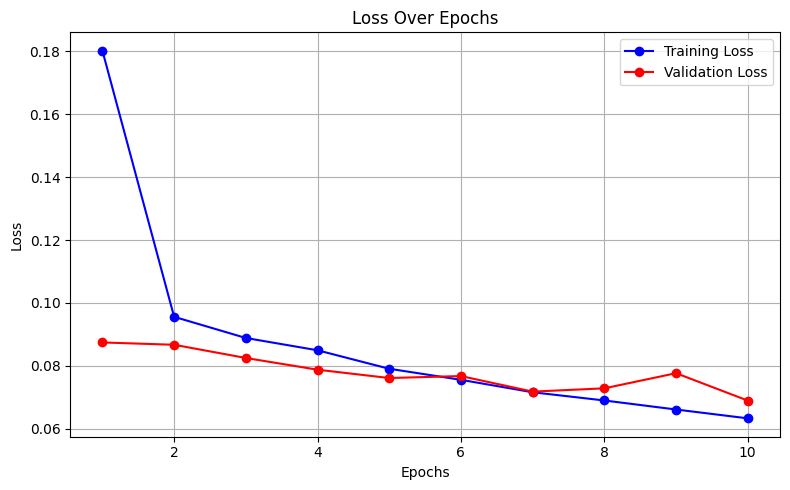

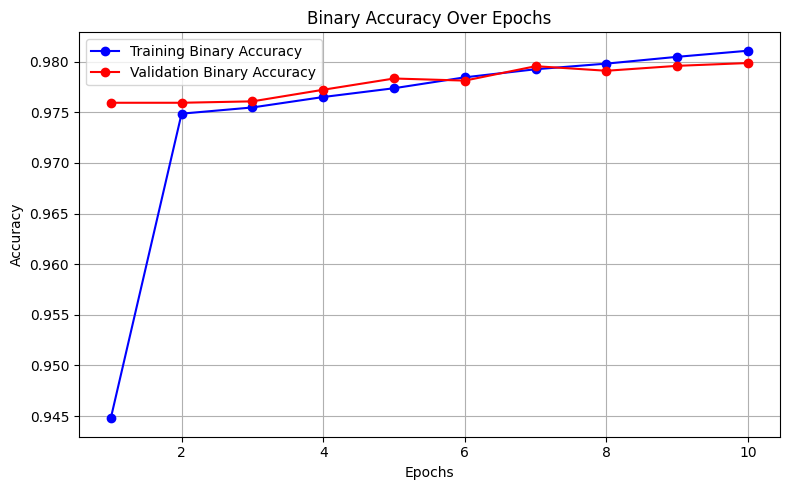

In [19]:
import matplotlib.pyplot as plt

def plot_metric(history, metric, val_metric=None, title='', ylabel=''):
    plt.figure(figsize=(8, 5))
    epochs = range(1, len(history[metric]) + 1)

    plt.plot(epochs, history[metric], 'bo-', label=f'Training {title}')

    if val_metric and val_metric in history:
        plt.plot(epochs, history[val_metric], 'ro-', label=f'Validation {title}')

    plt.title(f'{title} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Replace these with actual keys from print(history.history.keys())
plot_metric(history.history, 'loss', 'val_loss', 'Loss', 'Loss')
plot_metric(history.history, 'binary_accuracy', 'val_binary_accuracy', 'Binary Accuracy', 'Accuracy')
# plot_metric(history.history, 'auc', 'val_auc', 'AUC', 'AUC')  # Only if 'auc' exists



**Evaluation**

In [20]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

# Collect true and predicted values
y_val = []
y_val_pred_probs = []

for x_batch, y_batch in val_dataset:
    preds = model.predict(x_batch, verbose=0)
    y_val_pred_probs.append(preds)
    y_val.append(y_batch.numpy())

# Concatenate all batches
y_val = np.concatenate(y_val, axis=0)
y_val_pred_probs = np.concatenate(y_val_pred_probs, axis=0)

# Apply threshold
threshold = 0.5
y_val_pred_binary = (y_val_pred_probs > threshold).astype(int)

# Compute binary accuracy
binary_acc = np.mean((y_val == y_val_pred_binary).astype(int))
print(f" (threshold={threshold}): {binary_acc * 100:.2f}%")

# Compute macro F1 Score
macro_f1 = f1_score(y_val, y_val_pred_binary, average='macro', zero_division=0)
print(f"Macro F1 Score: {macro_f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_binary, zero_division=0))


 (threshold=0.5): 97.99%
Macro F1 Score: 0.0608

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.48      0.60       132
           1       0.00      0.00      0.00        38
           2       0.77      0.64      0.70       102
           3       0.00      0.00      0.00        46
           4       0.73      0.47      0.57        34
           5       0.00      0.00      0.00        23
           6       0.75      0.05      0.09        65
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00        11
          11       0.53      0.33      0.41        72
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00        26
         

In [21]:
def plot_confusion_matrix_per_class(y_true, y_pred, class_idx, class_name):
    cm = confusion_matrix(y_true[:, class_idx], y_pred[:, class_idx])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for class: {class_name}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'], rotation=0)
    plt.show()

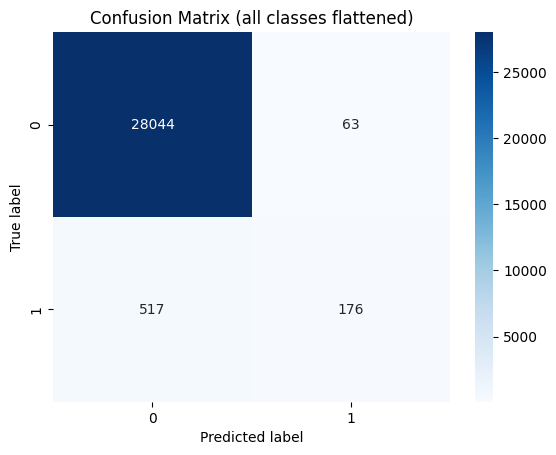

In [22]:
cm = confusion_matrix(y_val.flatten(), y_val_pred_binary.flatten())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (all classes flattened)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

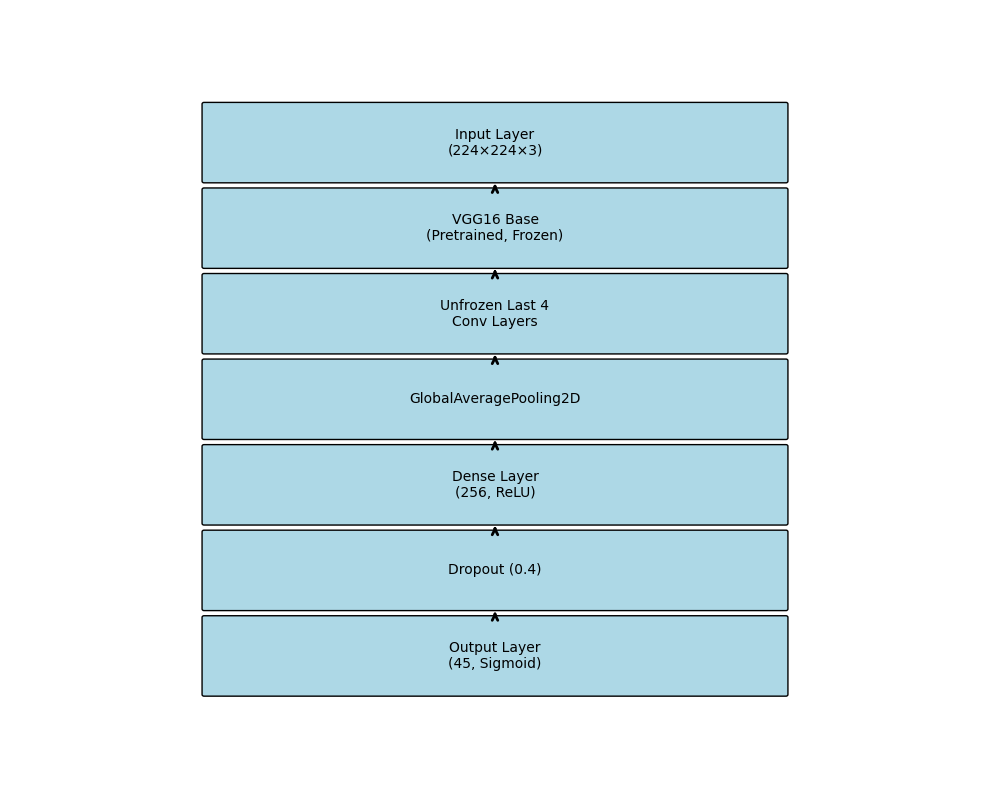

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

layers = [
    "Input Layer\n(224×224×3)",
    "VGG16 Base\n(Pretrained, Frozen)",
    "Unfrozen Last 4\nConv Layers",
    "GlobalAveragePooling2D",
    "Dense Layer\n(256, ReLU)",
    "Dropout (0.4)",
    "Output Layer\n(45, Sigmoid)"
]

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, len(layers) + 2)
ax.axis('off')

for i, layer in enumerate(layers):
    y = len(layers) - i
    rect = patches.FancyBboxPatch(
        (2, y), 6, 0.9,
        boxstyle="round,pad=0.02",
        edgecolor="black",
        facecolor="#add8e6"
    )
    ax.add_patch(rect)
    ax.text(5, y + 0.45, layer, fontsize=10, ha='center', va='center')
    if i < len(layers) - 1:
        ax.annotate('', xy=(5, y), xytext=(5, y - 0.1),
                    arrowprops=dict(arrowstyle="->", lw=2))

plt.tight_layout()
plt.savefig("model_architecture_vgg16.png", dpi=300)


In [123]:
##Matrix for all classes
#for i, class_name in enumerate(class_names):
#    plot_confusion_matrix_per_class(y_val, y_val_pred_binary, i, class_name)

# Model 2

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, SeparableConv2D, MaxPooling2D,
                                     Dropout, Flatten, Dense, BatchNormalization,
                                     Add, Activation, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def swish(x):
    return x * tf.keras.backend.sigmoid(x)

def create_advanced_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', activation=None)(inputs)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.15)(x)

    # Block 2
    x = SeparableConv2D(64, (3, 3), padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)

    # Block 3 with Residual
    shortcut = x
    x = SeparableConv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)
    x = SeparableConv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    x = Activation(swish)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Classification Head (GlobalAvg instead of Flatten)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
            tf.keras.metrics.AUC(name="auc")
        ]
    )

    return model


In [25]:
history2 = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=10, 
                    batch_size=32)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - auc: 0.9417 - binary_accuracy: 0.9808 - loss: 0.0625 - val_auc: 0.9103 - val_binary_accuracy: 0.9787 - val_loss: 0.0726
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - auc: 0.9383 - binary_accuracy: 0.9805 - loss: 0.0656 - val_auc: 0.9049 - val_binary_accuracy: 0.9792 - val_loss: 0.0717
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - auc: 0.9417 - binary_accuracy: 0.9812 - loss: 0.0621 - val_auc: 0.9094 - val_binary_accuracy: 0.9792 - val_loss: 0.0716
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - auc: 0.9466 - binary_accuracy: 0.9819 - loss: 0.0592 - val_auc: 0.9070 - val_binary_accuracy: 0.9796 - val_loss: 0.0727
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - auc: 0.9531 - binary_accuracy: 0.9815 - loss: 0.0569 - val_auc: 0.9110 - val_binary_accuracy: 0.9791 - val_loss: 0.0718
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - auc: 0.9571 - binary_accuracy: 0.9822 - loss: 0.0552 - val_auc: 0.8846 - val_binar

**Evaluation**

In [30]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

# ✅ Store predictions
y_val = []
y_val_pred_probs = []

for x_batch, y_batch in val_dataset:
    preds = model.predict(x_batch, verbose=0)
    y_val_pred_probs.append(preds)
    y_val.append(y_batch.numpy())

# ✅ Concatenate all batches
y_val = np.concatenate(y_val, axis=0)
y_val_pred_probs = np.concatenate(y_val_pred_probs, axis=0)

# ✅ Apply threshold
threshold = 0.3
y_val_pred_binary = (y_val_pred_probs > threshold).astype(int)

# ✅ Compute Binary Accuracy
binary_acc = np.mean((y_val == y_val_pred_binary).astype(int))
print(f"Binary Accuracy (threshold={threshold}): {binary_acc:.4f}")

# ✅ Compute Macro F1 Score
macro_f1 = f1_score(y_val, y_val_pred_binary, average='macro', zero_division=0)
print(f"Macro F1 Score: {macro_f1:.4f}")

# ✅ Full Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_binary, zero_division=0))


Binary Accuracy (threshold=0.3): 0.9762
Macro F1 Score: 0.1051

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.66      0.64       132
           1       0.33      0.53      0.41        38
           2       0.68      0.79      0.73       102
           3       0.27      0.09      0.13        46
           4       0.44      0.76      0.56        34
           5       0.40      0.17      0.24        23
           6       0.48      0.46      0.47        65
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00        11
          11       0.38      0.39      0.39        72
          12       0.17      0.12      0.14         8
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00     

In [31]:
report = classification_report(y_val, y_val_pred_binary, target_names=class_names)

print(report)

              precision    recall  f1-score   support

          DR       0.62      0.66      0.64       132
        ARMD       0.33      0.53      0.41        38
          MH       0.68      0.79      0.73       102
          DN       0.27      0.09      0.13        46
         MYA       0.44      0.76      0.56        34
        BRVO       0.40      0.17      0.24        23
        TSLN       0.48      0.46      0.47        65
         ERM       0.00      0.00      0.00         7
          LS       0.00      0.00      0.00        17
          MS       0.00      0.00      0.00         5
         CSR       0.00      0.00      0.00        11
         ODC       0.38      0.39      0.39        72
        CRVO       0.17      0.12      0.14         8
          TV       0.00      0.00      0.00         2
          AH       0.00      0.00      0.00         4
         ODP       0.00      0.00      0.00        26
         ODE       0.59      0.62      0.60        21
          ST       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

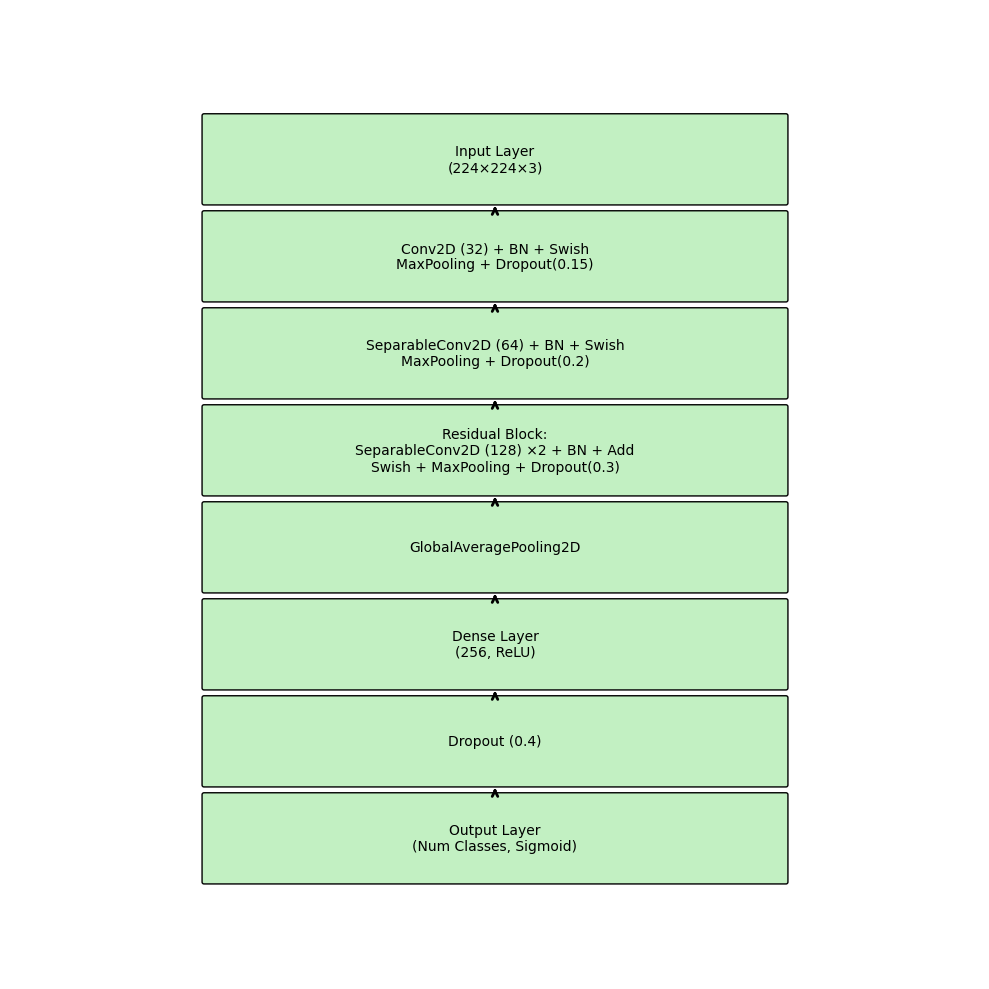

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

layers = [
    "Input Layer\n(224×224×3)",
    "Conv2D (32) + BN + Swish\nMaxPooling + Dropout(0.15)",
    "SeparableConv2D (64) + BN + Swish\nMaxPooling + Dropout(0.2)",
    "Residual Block:\nSeparableConv2D (128) ×2 + BN + Add\nSwish + MaxPooling + Dropout(0.3)",
    "GlobalAveragePooling2D",
    "Dense Layer\n(256, ReLU)",
    "Dropout (0.4)",
    "Output Layer\n(Num Classes, Sigmoid)"
]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, len(layers) + 2)
ax.axis('off')

for i, layer in enumerate(layers):
    y = len(layers) - i
    rect = patches.FancyBboxPatch(
        (2, y), 6, 0.9,
        boxstyle="round,pad=0.02",
        edgecolor="black",
        facecolor="#c2f0c2"  # Light Green
    )
    ax.add_patch(rect)
    ax.text(5, y + 0.45, layer, fontsize=10, ha='center', va='center')

    if i < len(layers) - 1:
        ax.annotate('', xy=(5, y), xytext=(5, y - 0.1),
                    arrowprops=dict(arrowstyle="->", lw=2))

plt.tight_layout()
plt.savefig("model_architecture_advanced_cnn.png", dpi=300)


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_per_class(y_true, y_pred, class_idx, class_name):
    """
    Plot confusion matrix for a specific class (index).
    
    Args:
        y_true (np.array): Ground truth binary labels (shape: [n_samples, n_classes])
        y_pred (np.array): Predicted binary labels (same shape as y_true)
        class_idx (int): Index of the class to visualize
        class_name (str): Name of the class (used in title)
    """
    cm = confusion_matrix(y_true[:, class_idx], y_pred[:, class_idx])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for class: {class_name}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'], rotation=0)
    plt.tight_layout()
    plt.show()


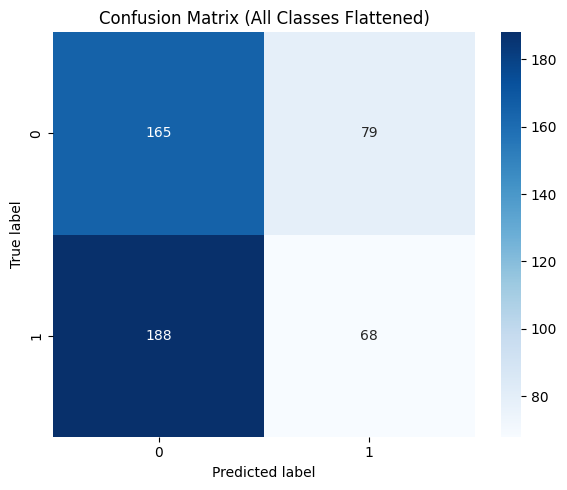

In [36]:
# Flattened confusion matrix across all classes
cm = confusion_matrix(y_val.flatten(), y_val_pred_binary.flatten())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (All Classes Flattened)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


In [128]:
# from sklearn.metrics import average_precision_score

# # Calculate Average Precision for each class
# avg_precision = average_precision_score(y_val, y_val_pred_probs, average=None)

# for i, class_name in enumerate(class_names):
#     print(f"Class: {class_name} - Average Precision: {avg_precision[i]:.4f}")

In [129]:
# import pandas as pd
# class_performance = pd.DataFrame({
#     'Class': class_names,
#     'Average Precision': avg_precision
# })

# class_performance = class_performance.sort_values('Average Precision', ascending=False)


# plt.figure(figsize=(12, 6))
# sns.barplot(x='Average Precision', y='Class', data=class_performance)
# plt.title('Average Precision per Class')
# plt.xlabel('Average Precision')
# plt.ylabel('Class')
# plt.show()

# Model 3: class weights

In [130]:
class_counts = train_label_df.drop(columns=train_label_df.columns[:2]).sum(axis=0)

print(class_counts)

DR      376
ARMD    100
MH      317
DN      138
MYA     101
BRVO     73
TSLN    186
ERM      14
LS       47
MS       15
CSR      37
ODC     282
CRVO     28
TV        6
AH       16
ODP      65
ODE      58
ST        5
AION     17
PT       11
RT       14
RS       43
CRS      32
EDN      15
RPEC     22
MHL      11
RP        6
CWS       3
CB        1
ODPM      0
PRH       2
MNF       3
HR        0
CRAO      2
TD        3
CME       4
PTCR      5
CF        3
VH        1
MCA       1
VS        1
BRAO      2
PLQ       1
HPED      1
CL        1
dtype: int64


In [131]:
class_weights = {i: (class_counts.sum() / (len(class_counts) * class_counts[i])) 
                 for i in range(len(class_counts)) if class_counts[i] > 0}

# Print the class weights
print("Class Weights:", class_weights)

Class Weights: {0: 0.12228132387706855, 1: 0.4597777777777778, 2: 0.14504030844724852, 3: 0.33317230273752013, 4: 0.45522552255225524, 5: 0.6298325722983257, 6: 0.24719235364396655, 7: 3.284126984126984, 8: 0.9782505910165484, 9: 3.065185185185185, 10: 1.2426426426426427, 11: 0.16304176516942476, 12: 1.642063492063492, 13: 7.662962962962963, 14: 2.873611111111111, 15: 0.7073504273504273, 16: 0.79272030651341, 17: 9.195555555555556, 18: 2.704575163398693, 19: 4.179797979797979, 20: 3.284126984126984, 21: 1.069250645994832, 22: 1.4368055555555554, 23: 3.065185185185185, 24: 2.0898989898989897, 25: 4.179797979797979, 26: 7.662962962962963, 27: 15.325925925925926, 28: 45.977777777777774, 30: 22.988888888888887, 31: 15.325925925925926, 33: 22.988888888888887, 34: 15.325925925925926, 35: 11.494444444444444, 36: 9.195555555555556, 37: 15.325925925925926, 38: 45.977777777777774, 39: 45.977777777777774, 40: 45.977777777777774, 41: 22.988888888888887, 42: 45.977777777777774, 43: 45.9777777777777

/tmp/ipykernel_36/3085749574.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in range(len(class_counts)) if class_counts[i] > 0}
/tmp/ipykernel_36/3085749574.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights = {i: (class_counts.sum() / (len(class_counts) * class_counts[i]))


In [132]:
history3 = model.fit(
    train_dataset, 
    epochs=10, 
    batch_size=32,  
    class_weight=class_weights  
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - auc_4: 0.9508 - binary_accuracy: 0.9820 - loss: 0.0524
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc_4: 0.8768 - binary_accuracy: 0.9774 - loss: 0.0591
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc_4: 0.8895 - binary_accuracy: 0.9764 - loss: 0.0616
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc_4: 0.8574 - binary_accuracy: 0.9763 - loss: 0.0577
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc_4: 0.8841 - binary_accuracy: 0.9771 - loss: 0.0610
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc_4: 0.8887 - binary_accuracy: 0.9765 - loss: 0.0568
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc_4: 0.9018 - binary_accuracy: 0.9776 - loss: 0.0463
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc_4: 0.9020 - binary_accuracy: 0.9784 - loss: 0.0495
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc_4: 0.9020 - binary_accuracy: 0.9773 - loss: 0.0509
Epoch 10/10
60/60 ━━━━━━━━━━

**Evaluation**

In [133]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

# 1. Prediction collection
y_val = []
y_val_pred_probs = []

for x_batch, y_batch in val_dataset:
    preds = model.predict(x_batch, verbose=0)
    y_val_pred_probs.append(preds)
    y_val.append(y_batch.numpy())

# 2. Concatenate predictions and labels
y_val = np.concatenate(y_val, axis=0)
y_val_pred_probs = np.concatenate(y_val_pred_probs, axis=0)

# 3. Apply threshold to get binary predictions
threshold = 0.3
y_val_pred_binary = (y_val_pred_probs > threshold).astype(int)

# 4. Binary Accuracy (mean match across all labels)
binary_acc = np.mean((y_val == y_val_pred_binary).astype(int))
print(f"Binary Accuracy (threshold={threshold}): {binary_acc:.4f}")

# 5. Macro F1 Score (treats all labels equally)
macro_f1 = f1_score(y_val, y_val_pred_binary, average='macro', zero_division=0)
print(f"Macro F1 Score: {macro_f1:.4f}")

# 6. Full classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_binary, zero_division=0))


Binary Accuracy (threshold=0.3): 0.9738
Macro F1 Score: 0.0784

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.13      0.23       132
           1       0.00      0.00      0.00        38
           2       0.76      0.13      0.22       102
           3       0.00      0.00      0.00        46
           4       0.86      0.53      0.65        34
           5       0.57      0.35      0.43        23
           6       0.58      0.17      0.26        65
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00        11
          11       0.46      0.17      0.24        72
          12       0.50      0.12      0.20         8
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00     

In [134]:
report = classification_report(y_val, y_val_pred_binary, target_names=class_names)

print(report)

              precision    recall  f1-score   support

          DR       0.94      0.13      0.23       132
        ARMD       0.00      0.00      0.00        38
          MH       0.76      0.13      0.22       102
          DN       0.00      0.00      0.00        46
         MYA       0.86      0.53      0.65        34
        BRVO       0.57      0.35      0.43        23
        TSLN       0.58      0.17      0.26        65
         ERM       0.00      0.00      0.00         7
          LS       0.00      0.00      0.00        17
          MS       0.00      0.00      0.00         5
         CSR       0.00      0.00      0.00        11
         ODC       0.46      0.17      0.24        72
        CRVO       0.50      0.12      0.20         8
          TV       0.00      0.00      0.00         2
          AH       0.00      0.00      0.00         4
         ODP       0.00      0.00      0.00        26
         ODE       0.55      0.52      0.54        21
          ST       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

# Model 4: class weights and focal loss

In [135]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)
    return focal_loss_fixed

In [136]:
model.compile(optimizer='adam',
              loss=focal_loss(gamma=2., alpha=0.25),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

In [137]:
model.fit(train_dataset,
          epochs=10,
          batch_size=32,
          class_weight=class_weights,
          validation_data=val_dataset)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - auc_5: 0.8934 - binary_accuracy: 0.9314 - loss: 0.0783 - val_auc_5: 0.8412 - val_binary_accuracy: 0.7061 - val_loss: 0.0490
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - auc_5: 0.8641 - binary_accuracy: 0.6506 - loss: 0.0177 - val_auc_5: 0.8262 - val_binary_accuracy: 0.6077 - val_loss: 0.0509
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - auc_5: 0.8253 - binary_accuracy: 0.5143 - loss: 0.0192 - val_auc_5: 0.8294 - val_binary_accuracy: 0.3794 - val_loss: 0.0177
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - auc_5: 0.8160 - binary_accuracy: 0.3915 - loss: 0.0139 - val_auc_5: 0.8190 - val_binary_accuracy: 0.2543 - val_loss: 0.0120
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - auc_5: 0.7795 - binary_accuracy: 0.2697 - loss: 0.0147 - val_auc_5: 0.7490 - val_binary_accuracy: 0.0964 - val_loss: 0.0081
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - auc_5: 0.7360 - binary_accuracy: 0.1651 - loss: 0.0026 - val

**Evaluation**

In [138]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
import numpy as np

# Step 1: Predict on validation set
y_val = []
y_val_pred_probs = []

for x_batch, y_batch in val_dataset:
    preds = model.predict(x_batch, verbose=0)
    y_val_pred_probs.append(preds)
    y_val.append(y_batch.numpy())

# Step 2: Concatenate all predictions and true labels
y_val = np.concatenate(y_val, axis=0)
y_val_pred_probs = np.concatenate(y_val_pred_probs, axis=0)

# Step 3: Apply threshold
threshold = 0.3
y_val_pred_binary = (y_val_pred_probs > threshold).astype(int)

# Step 4: Evaluation
accuracy = accuracy_score(y_val, y_val_pred_binary)
macro_f1 = f1_score(y_val, y_val_pred_binary, average='macro', zero_division=0)

print(f"\nThreshold: {threshold}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")

# Optional: Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_binary, zero_division=0))



Threshold: 0.3
Accuracy: 0.0000
Macro F1 Score: 0.0439

Classification Report:
              precision    recall  f1-score   support

           0       0.21      1.00      0.34       132
           1       0.06      1.00      0.11        38
           2       0.16      1.00      0.27       102
           3       0.07      1.00      0.13        46
           4       0.05      1.00      0.10        34
           5       0.04      1.00      0.07        23
           6       0.10      1.00      0.18        65
           7       0.01      1.00      0.02         7
           8       0.03      1.00      0.05        17
           9       0.01      1.00      0.02         5
          10       0.02      1.00      0.03        11
          11       0.11      1.00      0.20        72
          12       0.01      1.00      0.02         8
          13       0.00      1.00      0.01         2
          14       0.01      1.00      0.01         4
          15       0.04      1.00      0.08        26
 

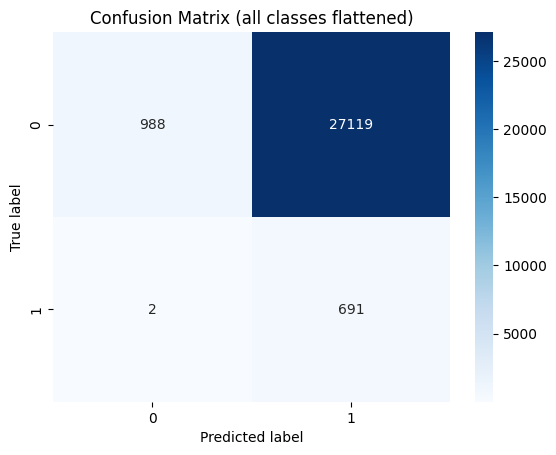

In [139]:
cm = confusion_matrix(y_val.flatten(), y_val_pred_binary.flatten())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (all classes flattened)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

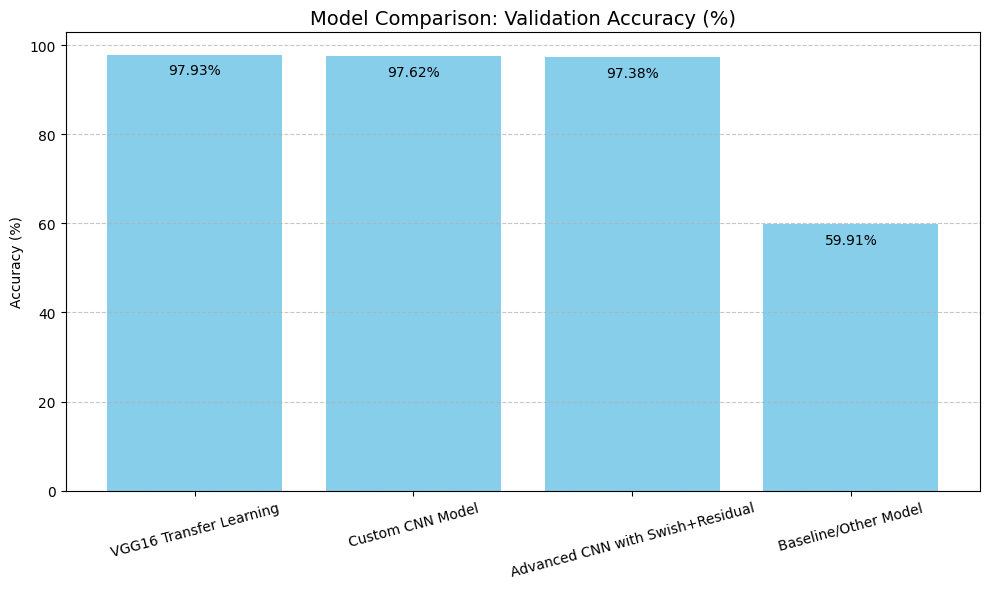

In [142]:
import matplotlib.pyplot as plt

# Names of your models
model_names = [
    "VGG16 Transfer Learning",
    "Custom CNN Model",
    "Advanced CNN with Swish+Residual",
    "Baseline/Other Model"
]

# Accuracy values (as fractions)
accuracies = [
    0.9793,  # VGG16
    0.9762,  # Custom CNN
    0.9738,  # Advanced CNN
    0.5991   # Baseline
]

# Convert accuracies to percentages
accuracies_percent = [acc * 100 for acc in accuracies]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies_percent, color='skyblue')
plt.ylim(0, max(accuracies_percent) + 5)  # Slightly higher than max for better text space
plt.title("Model Comparison: Validation Accuracy (%)", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=15)

# Annotate bars with accuracy percentage values
for bar, acc in zip(bars, accuracies_percent):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval - 2, f"{acc:.2f}%", ha='center', va='top', fontsize=10, color='black')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
